In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import ptitprince as pt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc
from scipy.stats import bootstrap

warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [4]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [5]:
def load_data(data,wt_seq,start_gap=0):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [6]:
def load_rosetta(data,wt_seq,gap):
    df=pd.read_csv(data, sep=' ', comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    count=1
    for i in range(len(wt_seq)):
            if wt_seq[i]!='-':
                for j in range(len(mutation_load)):
                    if int(mutation_load[j][1:len(mutation_load[j])-1])==count and mutation_load[j][len(mutation_load[j])-1]!= '=':
                        scores[i, alphabetAA_L_D[mutation_load[j][len(mutation_load[j])-1]]-1]= float(score_load[j])
            count+=1
    return scores

In [7]:
def print_chimera_x_attribute_file(attribute_check,attribute,file,model_id='#1',chain_id='/A',argument='cbyvalue'):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s%s\n%s\n%s\n' % ( 'attribute: ',argument,'match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True or attribute_check[i]==-99999:
            pass
        else:
            file.write("\t%s%s%s%d\t%f\n" % (str(model_id),str(chain_id),':',i+1,attribute[i]))
    file.close()

In [8]:
def heatmap_scores_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [9]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999):
    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("pearson's r:", pearson_output(x_s,y_s))
    
    #correlation line

    
    optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
    ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), pearson_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [10]:
def pearson_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [11]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

## Loading Datasets
### Load WT sequence

In [12]:
GCK_WT_sequence="MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ"
GCK_WT_ros_seq1='--------------MVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRH-----------------------NVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'
GCK_WT_ros_seq2='-------------TLVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'

### Load MAVE data

In [13]:
df_mave=pd.read_csv('../Inputs/select_t1_simple_aa.csv', sep=',', comment='#')

mutation_load=np.array(df_mave.iloc[:,0])
score_load=np.array(df_mave.iloc[:,1])
errors_load=np.array(df_mave.iloc[:,4])

GCK_scores=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores[:]=np.nan

GCK_errors=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        GCK_scores[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(score_load[i])
        GCK_errors[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(errors_load[i])

In [14]:
GCK_scores_med=np.nanmedian(GCK_scores,axis=1)

In [15]:
GCK_scores_inactivating=np.copy(GCK_scores)

for i in range(GCK_scores.shape[0]):
    for j in range(GCK_scores.shape[1]):
        
        if GCK_scores[i,j] >1.1:
            GCK_scores_inactivating[i,j]=np.nan

In [16]:
GCK_scores_inactivating_med=np.nanmedian(GCK_scores_inactivating,axis=1)

#### load synonimous and Term

In [17]:
GCK_synonimous_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_synonimous_mutations[:]=np.nan

GCK_stop_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_stop_mutations[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]=='=':
        GCK_synonimous_mutations[int(mutation_load[i][5:len(mutation_load[i])-1])-1, 0]= float(score_load[i])
        
    elif mutation_load[i][-3:] == 'Ter' :
        GCK_stop_mutations[int(mutation_load[i][5:len(mutation_load[i])-3])-1, 0]= float(score_load[i])

In [18]:
sp.nanstd(GCK_synonimous_mutations.flatten())

0.43153176745049027

### Load imputed score [Weile et al., 2017]

In [19]:
df_impute=pd.read_csv('../Inputs/P35557[GKC_all]_imputation.csv', sep=',', comment='#')

mutation_pos=np.array(df_impute.iloc[:,3])
mutation_mut=np.array(df_impute.iloc[:,4])
score_load=np.array(df_impute.iloc[:,26])

GCK_imputed=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_imputed[:]=np.nan

for i in range(len(mutation_pos)):
    if  mutation_mut[i]!= '*':
        GCK_imputed[int(mutation_pos[i])-1, alphabetAA_L_D[mutation_mut[i]]-1]= float(score_load[i])

#### Only imputed value heatmap

In [20]:
GCK_imputed_only=np.copy(GCK_imputed)

for (x, y), element in np.ndenumerate(GCK_scores):
    if np.isnan(element):
        pass
    else:
        GCK_imputed_only[x,y]=np.nan

### Load Clinical data

- 1 : MODY variant
- 2 : HH variant

In [21]:
df_clin=pd.read_csv('../Inputs/2021-10-19-disease-linked-variants-Osbak2009HumanMutation.csv', sep=',', comment='#')

mutation_load=np.array(df_clin.iloc[:,0])
score_load=np.array(df_clin.iloc[:,1])


GCK_disease=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_disease[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        if score_load[i]=='MODY':
            GCK_disease[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= 1
        elif score_load[i]=='HH':
            GCK_disease[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= 2

### Load Kinetics data

In [22]:
df_kinetics=pd.read_csv('../Inputs/2022-01-20-kinetic-characteristics.csv', sep=',', comment='#')
mutation_load=np.array(df_kinetics.iloc[:,0])
mutation_outs=['WT']

for i in range(1,len(mutation_load)):
    #print(str(alphabetAA_3L_1L[mutation_load[i][2:5]])+str(mutation_load[i][5:len(mutation_load[i])-3])+str(alphabetAA_3L_1L[mutation_load[i][-3:]]))
    mutation_outs.append(str(alphabetAA_3L_1L[mutation_load[i][2:5]])+str(mutation_load[i][5:len(mutation_load[i])-3])+str(alphabetAA_3L_1L[mutation_load[i][-3:]]))
    

df_kinetics['mutation_3l']=mutation_outs

### Load Glucose data

In [23]:
df_glucose=pd.read_csv('../Inputs/2021-11-30-Torben-Hansen-GCK-patient-data.csv', sep=',', comment='#')
mutation_load=np.array(df_glucose.iloc[:,5])
mutation_outs=[]
for i in range(0,len(mutation_load)):
    if mutation_load[i]=='Nan':
        mutation_outs.append('nan')
    else:
        mutation_outs.append(str(alphabetAA_3L_1L[mutation_load[i][2:5]])+str(mutation_load[i][5:len(mutation_load[i])-3])+str(alphabetAA_3L_1L[mutation_load[i][-3:]]))   
df_glucose['mutation_3l']=mutation_outs

### load gnomad frequencies

gnomad_GCK_freq=load_data("../Inputs/prism_gnomad_001_P35557-ENST00000403799-ENSG00000106633.mis.txt",GCK_WT_sequence)
gnomad_GCK_freq=remove_WT_score(gnomad_GCK_freq,GCK_WT_sequence)

In [24]:
gnomad_GCK_freq_db=pd.read_csv('../Inputs/gnomAD_v2.1.1_ENST00000403799_2021_12_13_16_16_50.csv')

In [25]:
gnomad_GCK_freq_db=gnomad_GCK_freq_db[gnomad_GCK_freq_db['Protein Consequence'].notna()].reset_index(drop=True)

In [26]:
gnomad_GCK_freq_db=gnomad_GCK_freq_db[gnomad_GCK_freq_db['VEP Annotation']=='missense_variant'].reset_index(drop=True)

In [27]:
gnomad_GCK_freq_db_matrix=np.empty((len(GCK_WT_sequence),20),dtype=float)
gnomad_GCK_freq_db_matrix[:]=np.nan

mutation_load=gnomad_GCK_freq_db['Protein Consequence'].to_numpy()
score_load=gnomad_GCK_freq_db['Allele Frequency'].to_numpy()
for i in range(1,len(mutation_load)):
        gnomad_GCK_freq_db_matrix[int(mutation_load[i][5:len(mutation_load[i])-3])-1,int(alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]])-1]=score_load[i]   

In [28]:
mutation=[]
gnomad_export=[]
for (i,j),k in ndenumerate(gnomad_GCK_freq_db_matrix):
    if np.isnan(k):
        pass
    else:
        mutation.append(GCK_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
        gnomad_export.append(k)
df_comp_export=pd.DataFrame({"mutation": mutation, 'gnomad allele frequency': gnomad_export})

In [29]:
df_comp_export.to_excel('../Output/gnomad_df_export.xlsx')

### Load computational data
- Rosetta Scores GCK

1v4s: close conformation with sugar

1v4t: open conformation without sugar

In [30]:
rosetta_GCK_1v4t_ddg=load_rosetta("../Inputs/prims_rosetta_GCK_1V4T.txt",GCK_WT_ros_seq1,0)
rosetta_GCK_1v4t_ddg=remove_WT_score(rosetta_GCK_1v4t_ddg,GCK_WT_sequence)

In [31]:
rosetta_GCK_1v4t_ddg_avg=np.nanmedian(rosetta_GCK_1v4t_ddg,axis=1)

In [32]:
rosetta_GCK_1v4s_ddg=load_rosetta("../Inputs/prims_rosetta_GCK_1V4S.txt",GCK_WT_ros_seq2,0)
rosetta_GCK_1v4s_ddg=remove_WT_score(rosetta_GCK_1v4s_ddg,GCK_WT_sequence)

In [33]:
rosetta_GCK_1v4s_ddg_avg=np.nanmedian(rosetta_GCK_1v4s_ddg,axis=1)

In [34]:
normalized_rosetta_scores_1v4s=np.copy(rosetta_GCK_1v4s_ddg)
c_min_act=np.percentile(rosetta_GCK_1v4s_ddg[~np.isnan(rosetta_GCK_1v4s_ddg)],5)
c_max_act=np.percentile(rosetta_GCK_1v4s_ddg[~np.isnan(rosetta_GCK_1v4s_ddg)],95)
print(c_max_act,c_min_act)
for i in range(rosetta_GCK_1v4s_ddg.shape[0]):
    for j in range(rosetta_GCK_1v4s_ddg.shape[1]):
        normalized_rosetta_scores_1v4s[i,j]=(rosetta_GCK_1v4s_ddg[i,j]-c_min_act)/(c_max_act-c_min_act)

7.750017241379304 -0.8057586206896932


In [35]:
normalized_rosetta_GCK_1v4s_ddg_avg=np.nanmedian(normalized_rosetta_scores_1v4s,axis=1)

- Co-evolution scores

In [36]:
coevo_GCK_scores=load_data("../Inputs/prism_GCK_gemme_scores.txt",GCK_WT_sequence)
coevo_GCK_scores=remove_WT_score(coevo_GCK_scores,GCK_WT_sequence)

In [37]:
coevo_GCK_scores_med=np.nanmedian(coevo_GCK_scores,axis=1)

## Heatmaps


In [38]:
GCK_scores_med[204]

-0.19702234844444116

### Experimental heatmaps

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


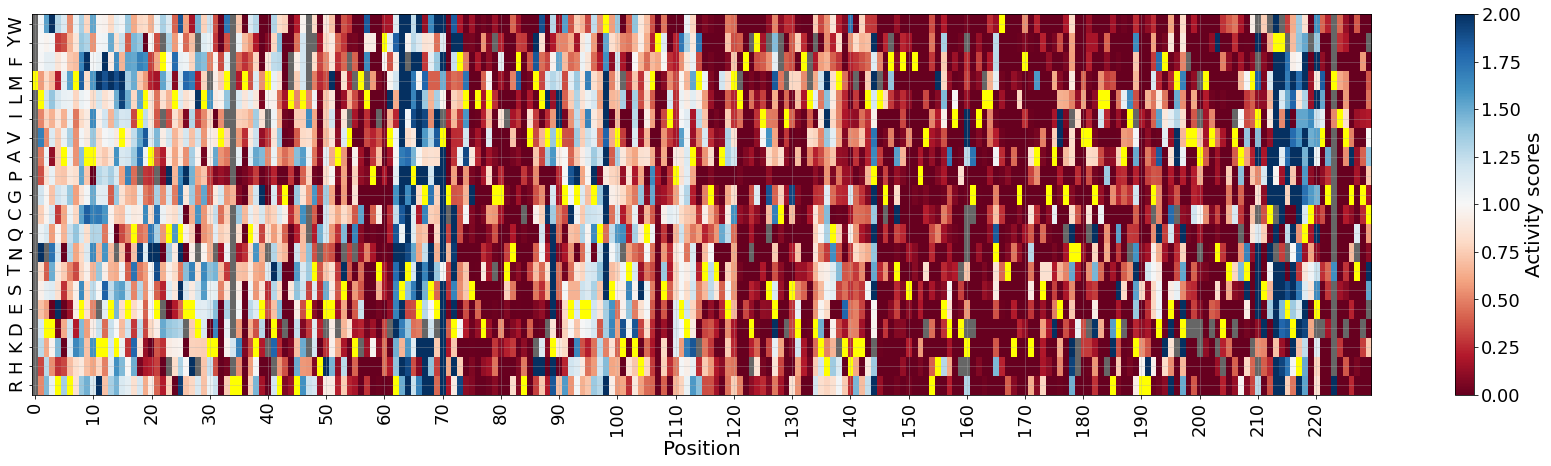

In [39]:
heatmap_scores_reordered(GCK_scores,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[0,229])
plt.savefig('../Figures/GCK_heatmap_MAVE_1_reordered.pdf',dpi=300, facecolor='w')

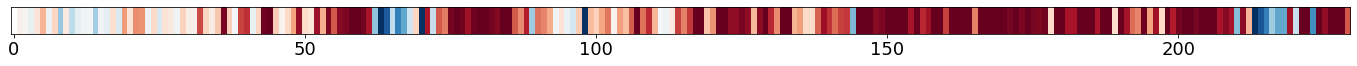

In [40]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,229.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/GCK_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('../Figures/GCK_heamap_MAVE_med_1.pdf',dpi=300, facecolor='w')

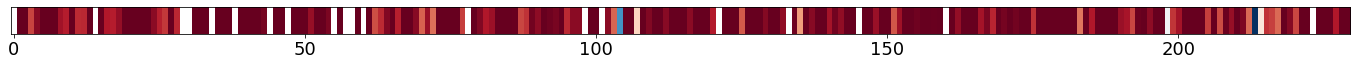

In [41]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(GCK_stop_mutations.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,229.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/GCK_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('../Figures/GCK_heamap_MAVE_stop_1.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


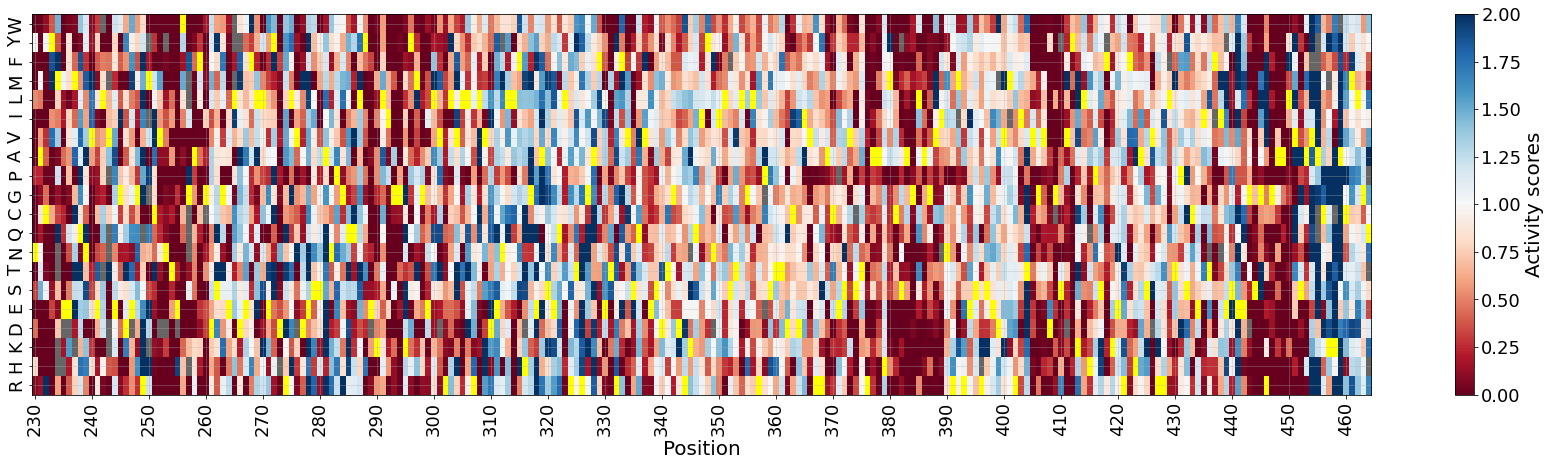

In [42]:
heatmap_scores_reordered(GCK_scores,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[230,len(GCK_WT_sequence)-1])
plt.savefig('../Figures/GCK_heatmap_MAVE_2_reordered.pdf',dpi=300, facecolor='w')

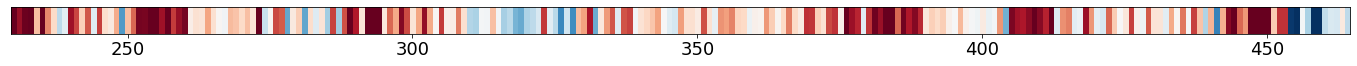

In [43]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(229.5,len(GCK_WT_sequence)-1+0.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/GCK_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('../Figures/GCK_heamap_MAVE_med_2.pdf',dpi=300, facecolor='w')

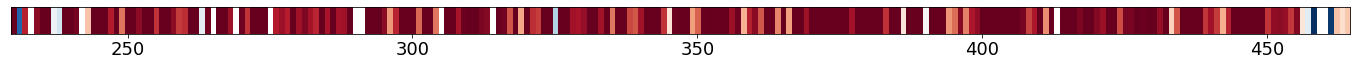

In [44]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(GCK_stop_mutations.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(229.5,len(GCK_WT_sequence)-1+0.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/GCK_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('../Figures/GCK_heamap_MAVE_stop_2.pdf',dpi=300, facecolor='w')

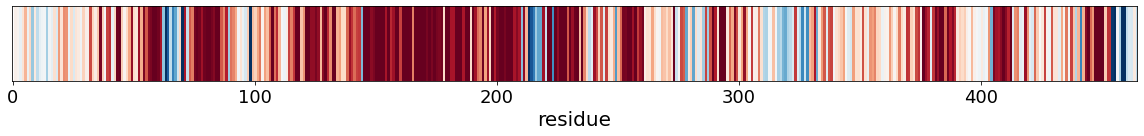

In [45]:
# Comparison with experimental MAVE residue colour classification
fig, (ax1) = plt.subplots(1,1,figsize=(16,2))

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='none')
ax1.set_yticks([])

ax1.set_xlabel('residue')

plt.tight_layout()
plt.savefig('../Figures/GCK_heatmap_MAVE_res.png',dpi=300, facecolor='w')

### Imputed scores heatmaps

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


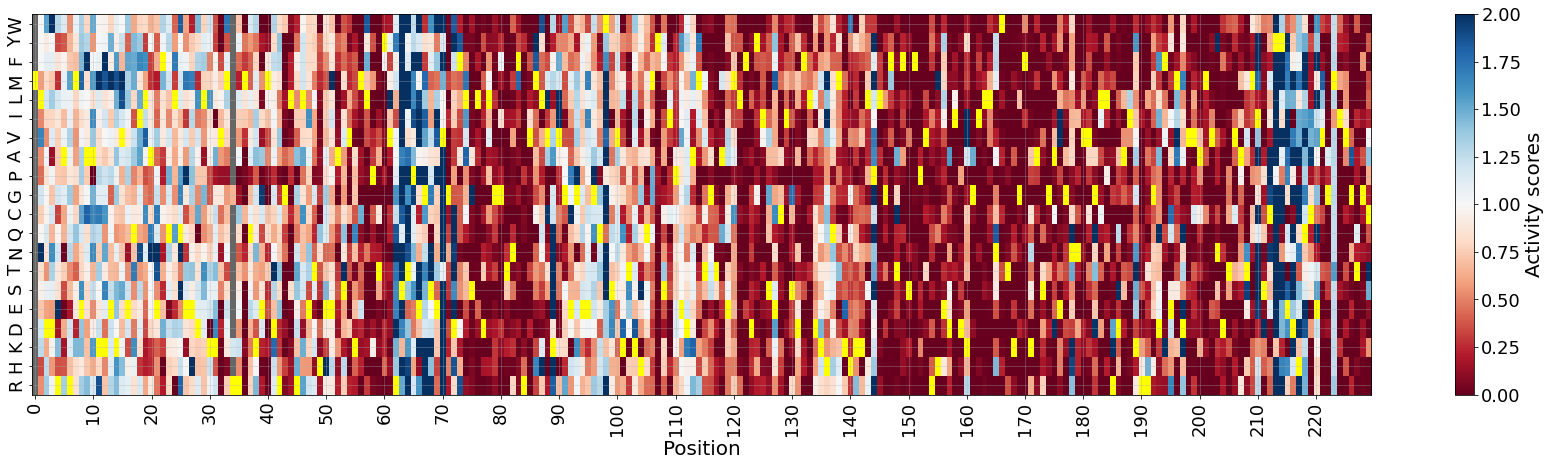

In [46]:
heatmap_scores_reordered(GCK_imputed,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[0,229])
plt.savefig('../Figures/GCK_heatmap_MAVE_1_imputed.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


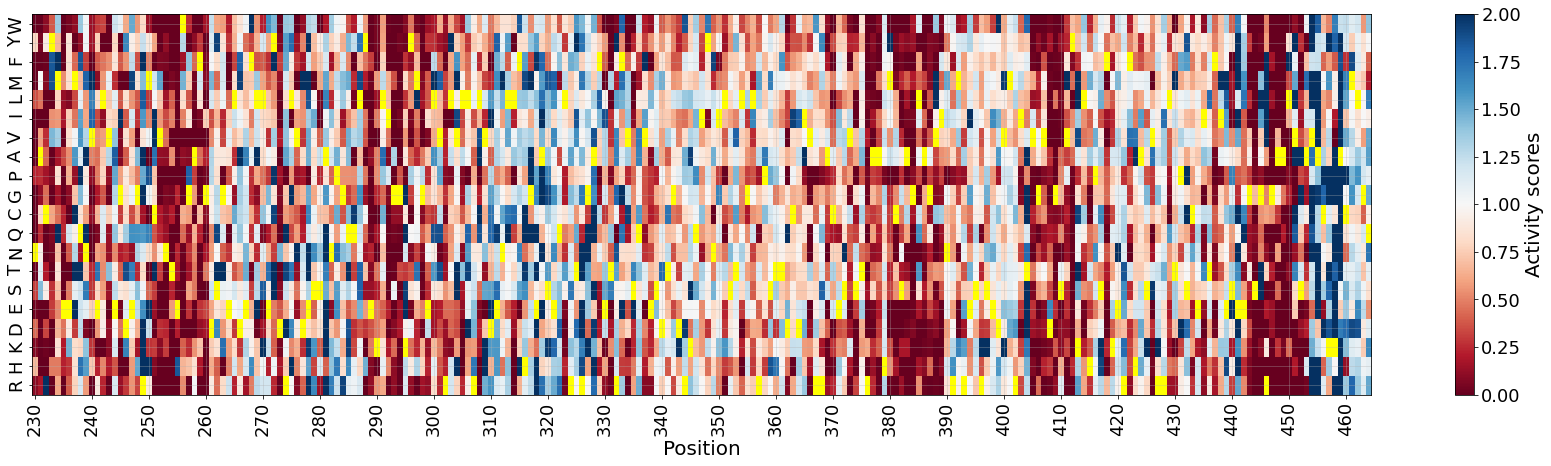

In [47]:
heatmap_scores_reordered(GCK_imputed,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[230,len(GCK_WT_sequence)-1])
plt.savefig('../Figures/GCK_heatmap_MAVE_2_imputed.pdf',dpi=300, facecolor='w')

##### Only imputed scores

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


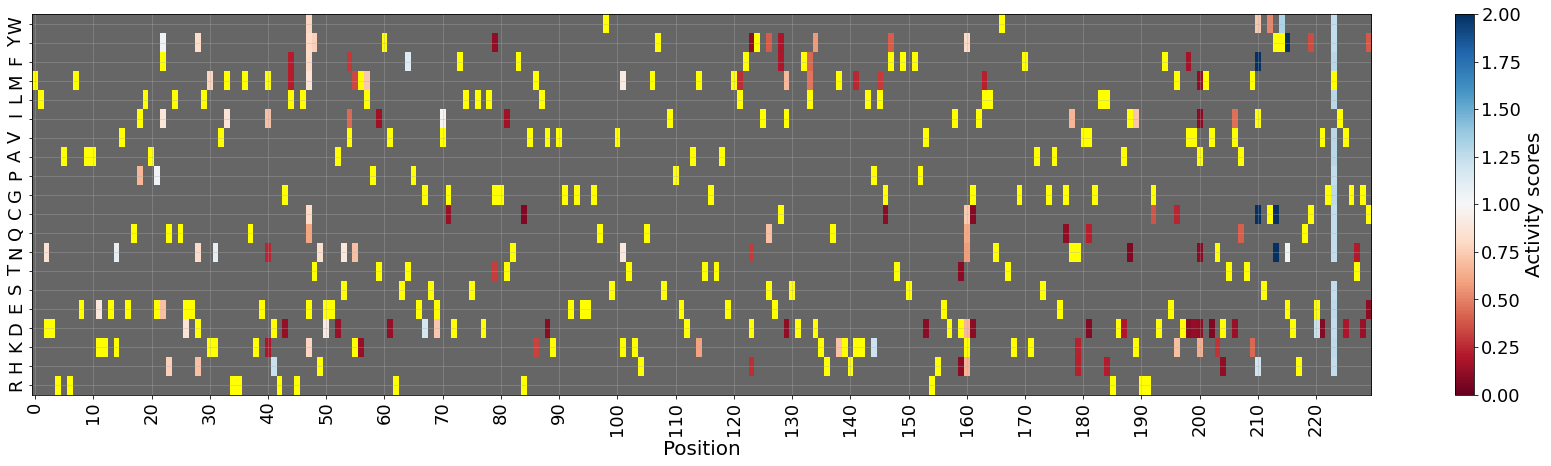

In [48]:
heatmap_scores_reordered(GCK_imputed_only,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[0,229])
plt.savefig('../Figures/GCK_heatmap_MAVE_1_imputed_only.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


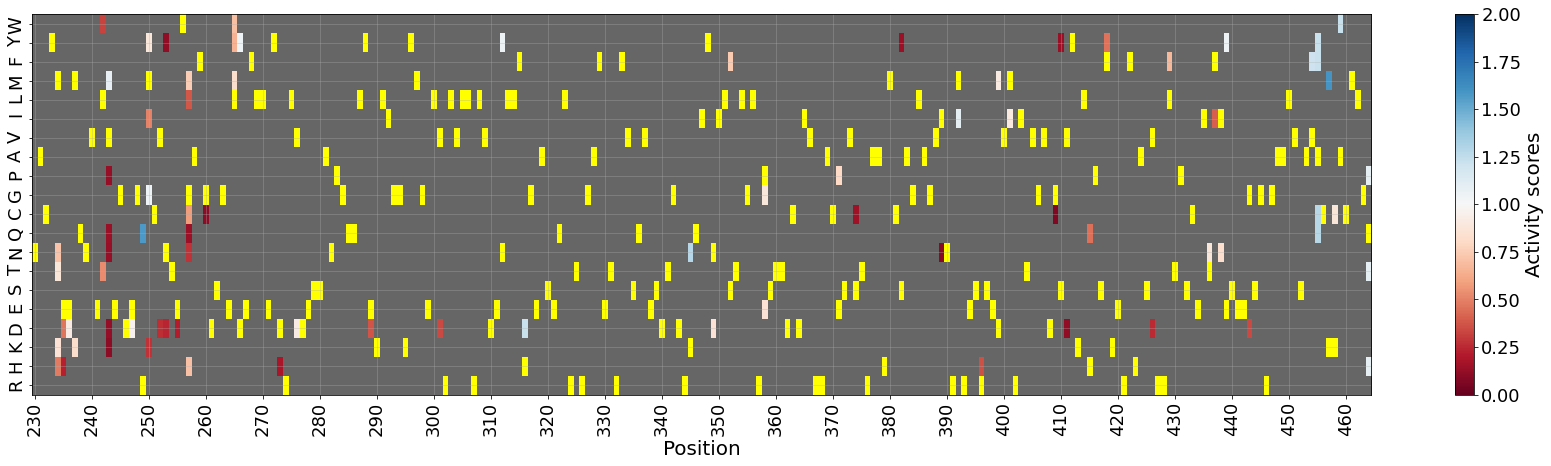

In [49]:
heatmap_scores_reordered(GCK_imputed_only,'Activity scores',GCK_WT_sequence,2,0,'RdBu',[230,len(GCK_WT_sequence)-1])
plt.savefig('../Figures/GCK_heatmap_MAVE_2_imputed_only.pdf',dpi=300, facecolor='w')

### Computational protocols heatmaps
- gemme scores

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


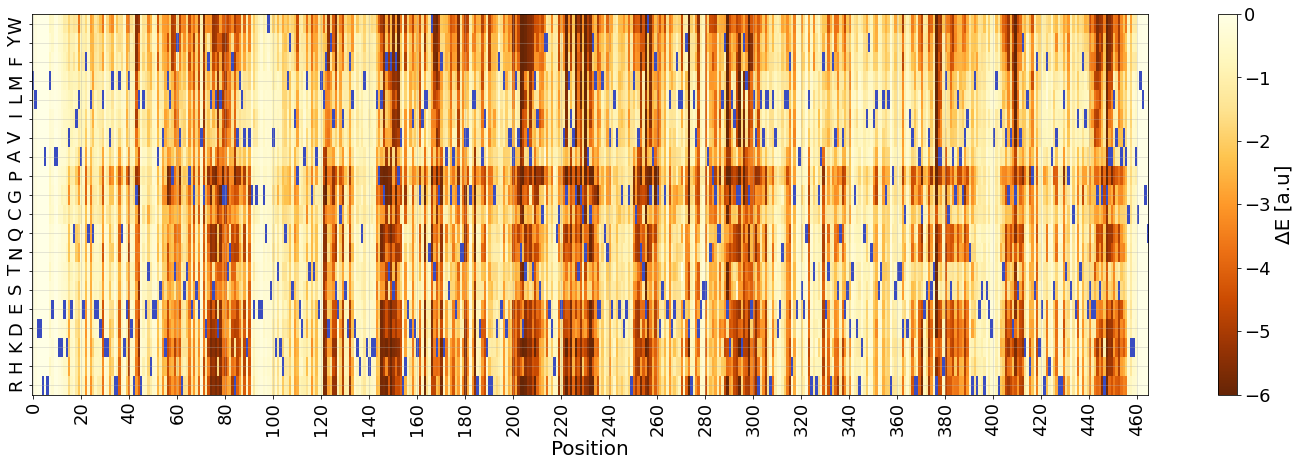

In [50]:
heatmap_scores_reordered(coevo_GCK_scores,'\u0394E [a.u]',GCK_WT_sequence,-6,0,'YlOrBr_r',[0,len(GCK_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[25,7])
plt.savefig('../Figures/GCK_heatmap_GEMME.pdf',dpi=300, facecolor='w')

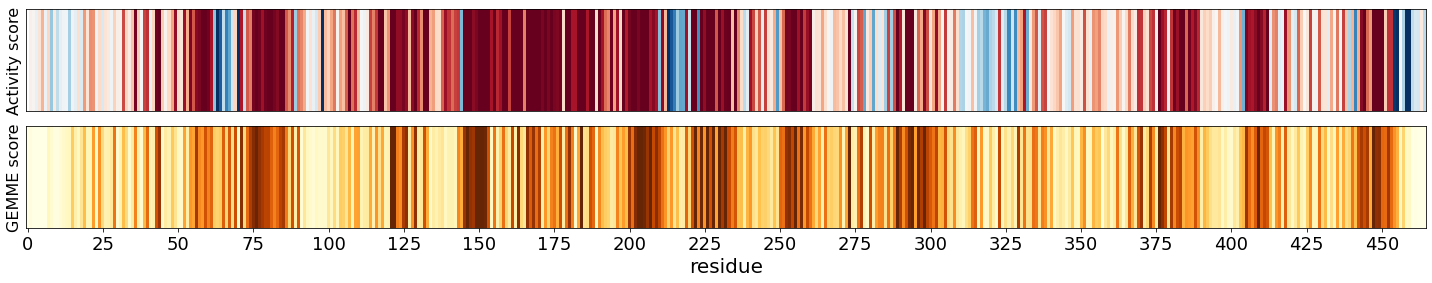

In [51]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=(20,4))

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('Activity score',fontsize=16)
ax1.set_xticks([])

#ax1.set_xlabel('residue')
ax2.imshow(coevo_GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlOrBr_r',vmin=-5,vmax=0,interpolation='nearest')
ax2.set_yticks([])

ax2.set_xlabel('residue')
ax2.set_ylabel('GEMME score',fontsize=16)
ax2.xaxis.set_ticks(np.arange(0, len(GCK_WT_sequence), 25))

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/GCK_comp_mode_comparison.pdf')
plt.tight_layout()
plt.savefig('../Figures/GCK_heatmap_coevo_res.pdf',dpi=300, facecolor='w')

In [97]:
print_chimera_x_attribute_file(rosetta_GCK_1v4s_ddg_avg,coevo_GCK_scores_med,'../output/chimera_gemme_scores.txt',model_id='#1',argument='gemme')

In [91]:
print_chimera_x_attribute_file(rosetta_GCK_1v4s_ddg_avg,rosetta_GCK_1v4t_ddg_avg,'../output/chimera_ddg_1v4t_med_scores.txt',model_id='#1',argument='ddg_1v4t')

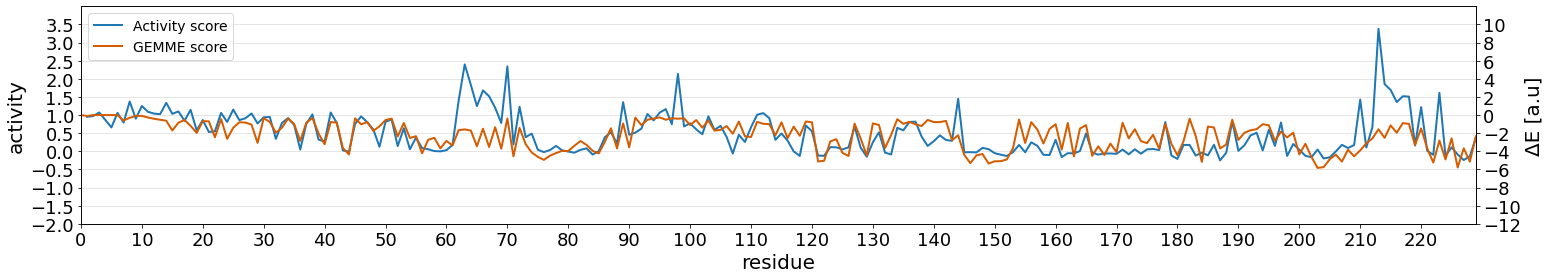

In [117]:
fig, ax1 = plt.subplots(figsize=(25,4))

x=[ i for i in range(len(GCK_scores_med)) ]
x=np.array(x)
 
lns1=ax1.plot(x,GCK_scores_med, label='Activity score',lw=2)

ax1.set_xlabel('residue')
ax1.set_ylabel('activity')
ax1.set_ylim(-2,4)
ax1.set_yticks(np.arange(-2,4,0.5))


ax2=ax1.twinx()
lns2=ax2.plot(x,coevo_GCK_scores_med,label='GEMME score',color='#d55c00',lw=2)
ax2.set_ylim(-12,12)
ax2.set_yticks(np.arange(-12,12,2))
ax2.set_ylabel("\u0394E [a.u]")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.grid(axis='y', alpha=0.4)
plt.xlim(0,229)
plt.xticks(np.arange(0,229,10))

plt.savefig('../Figures/GCK_heatmap_coevo_line_1.pdf',dpi=300, facecolor='w')

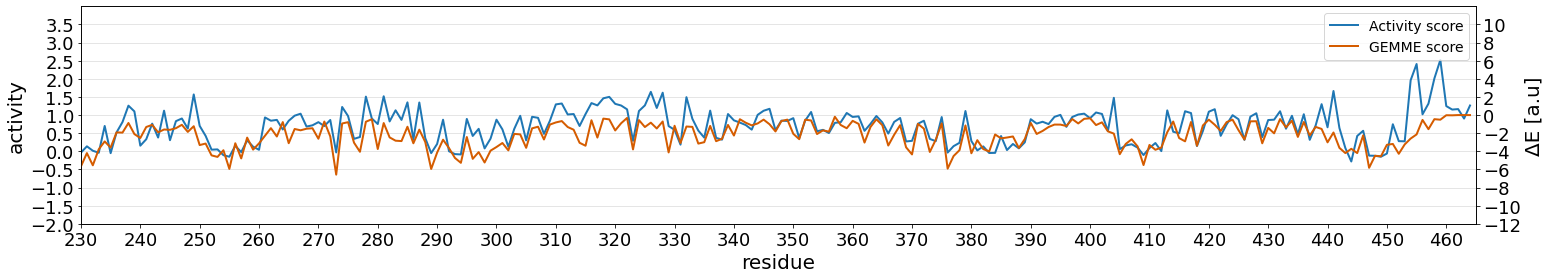

In [116]:
fig, ax1 = plt.subplots(figsize=(25,4))

x=[ i for i in range(len(GCK_scores_med)) ]
x=np.array(x)
 
lns1=ax1.plot(x,GCK_scores_med, label='Activity score',lw=2)

ax1.set_xlabel('residue')
ax1.set_ylabel('activity')
ax1.set_ylim(-2,4)
ax1.set_yticks(np.arange(-2,4,0.5))


ax2=ax1.twinx()
lns2=ax2.plot(x,coevo_GCK_scores_med,label='GEMME score',color='#d55c00',lw=2)
ax2.set_ylim(-12,12)
ax2.set_yticks(np.arange(-12,12,2))
ax2.set_ylabel("\u0394E [a.u]")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.grid(axis='y', alpha=0.4)
plt.xlim(230,len(GCK_WT_sequence))
plt.xticks(np.arange(230,len(GCK_WT_sequence),10))

plt.savefig('../Figures/GCK_heatmap_coevo_line_2.pdf',dpi=300, facecolor='w')

- Rosetta ddg

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


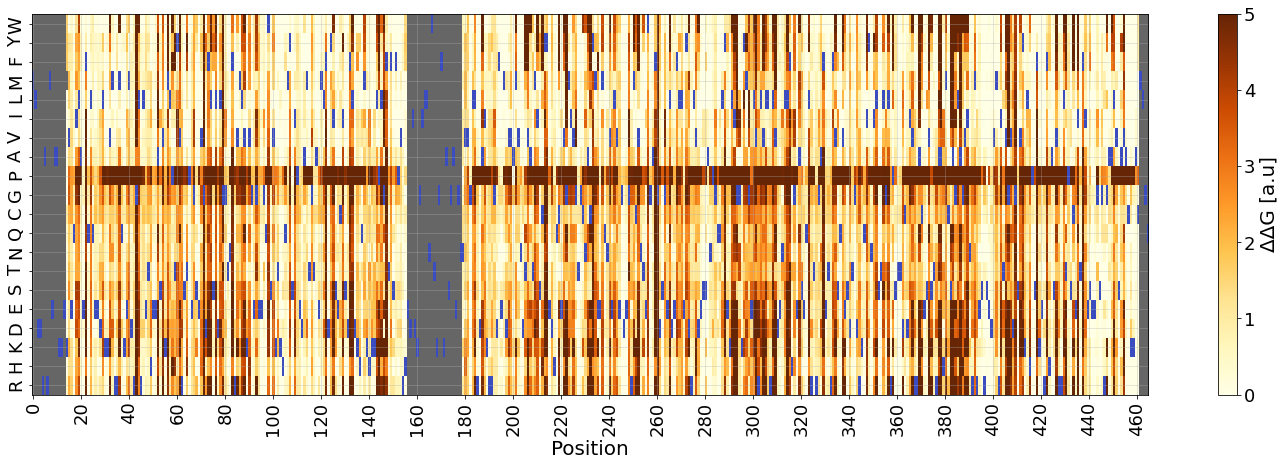

In [98]:
heatmap_scores_reordered(rosetta_GCK_1v4t_ddg,'\u0394\u0394G [a.u]',GCK_WT_sequence,0,5,'YlOrBr',[0,len(GCK_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[25,7])
#plt.savefig('./Figures/GCK_heatmap_drug_MAVE.pdf')
plt.savefig('../Figures/GCK_heatmap_ddg_1v4t.pdf',dpi=300, facecolor='w')

In [99]:
print_chimera_x_attribute_file(rosetta_GCK_1v4s_ddg_avg,rosetta_GCK_1v4s_ddg_avg,'../output/chimera_ddg_1v4s_med_scores.txt',model_id='#3',argument='ddg_1v4s')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


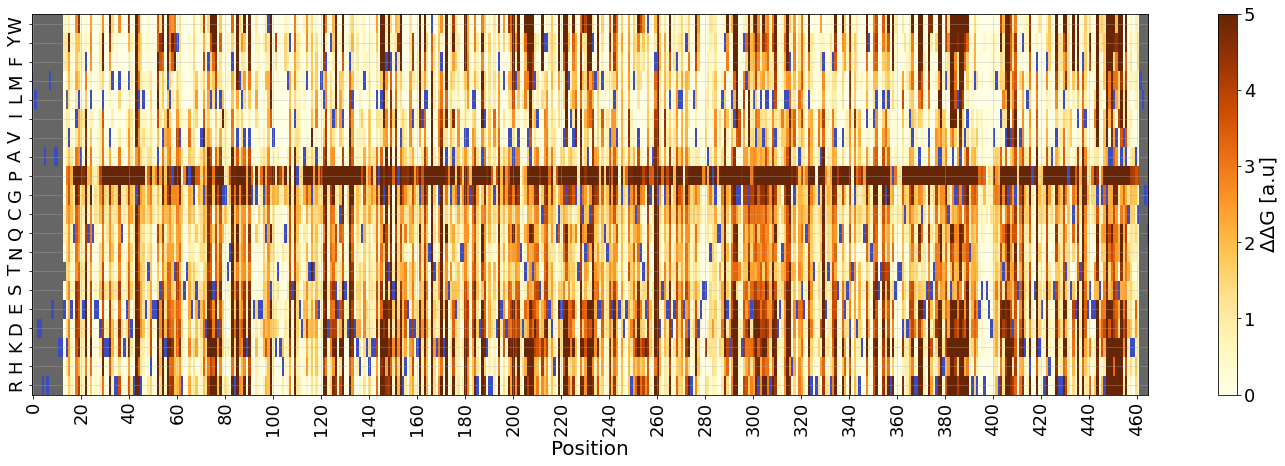

In [100]:
heatmap_scores_reordered(rosetta_GCK_1v4s_ddg,'\u0394\u0394G [a.u]',GCK_WT_sequence,0,5,'YlOrBr',[0,len(GCK_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[25,7])
#plt.savefig('./Figures/GCK_heatmap_drug_MAVE.pdf')
plt.savefig('../Figures/GCK_heatmap_ddg_1v4s.pdf',dpi=300, facecolor='w')

In [101]:
print_chimera_x_attribute_file(rosetta_GCK_1v4s_ddg_avg,rosetta_GCK_1v4t_ddg_avg,'../output/chimera_ddg_1v4t_med_scores.txt',model_id='#4',argument='ddg_1v4t')

### differences in rosetta scores:
- larger than 0 higher destabilization in OPEN conformation than close conformation 
- smaller than 0 higher destabilization in CLOSE conformation than in open conformation

In [73]:
rosetta_diff_ddg=rosetta_GCK_1v4t_ddg-rosetta_GCK_1v4s_ddg
rosetta_diff_ddg_med=np.nanmedian(rosetta_diff_ddg,axis=1)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


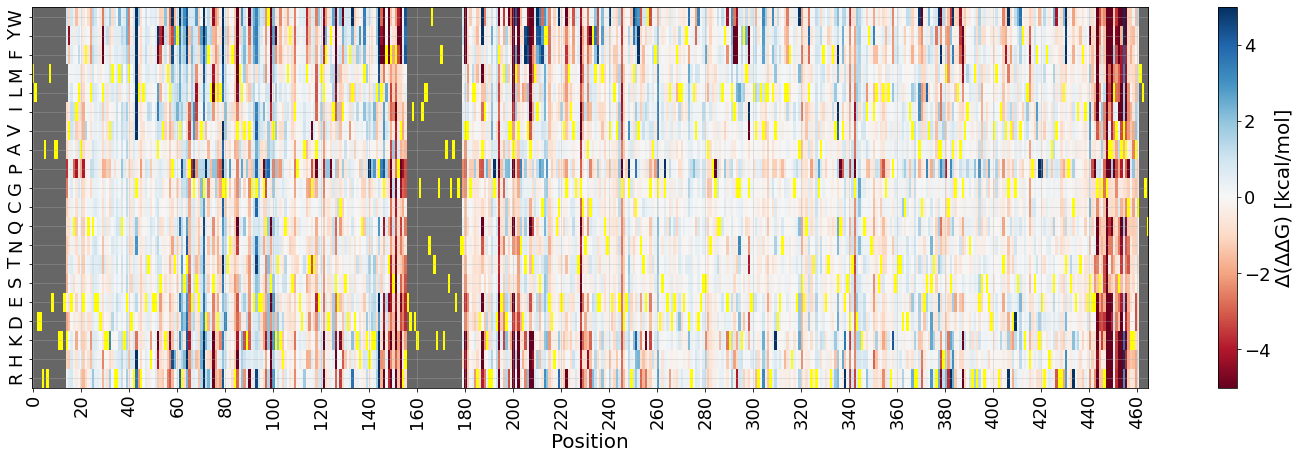

In [74]:
heatmap_scores_reordered(rosetta_diff_ddg,'\u0394(\u0394\u0394G) [kcal/mol]',GCK_WT_sequence,-5,5,'RdBu',[0,len(GCK_WT_sequence)-1],xtick_spacing=20,figs=[25,7])

plt.savefig('../Figures/GCK_heatmap_ddg_diff.pdf',dpi=300, facecolor='w')

In [75]:
#### print ddgs difference map:

file_p=open('../Output/GCK_ddg_sub_diffence.txt',"w+")
file_p.write('%s\n' % ( 'GCK ddG differences') )
file_p.write('%s\t%s\n' % ( "mutations","ddGdiff") )
for i in range(rosetta_diff_ddg.shape[0]):
    for j in range(rosetta_diff_ddg.shape[1]):
        if np.isnan(rosetta_diff_ddg[i,j])==True:
            file_p.write("%s%s%s\t%s\n" % (str(GCK_WT_sequence[i]),str(i+1),str(alphabetAA_D_L[j+1]),'np.nan'))
        else:
            file_p.write("%s%s%s\t%f\n" % (str(GCK_WT_sequence[i]),str(i+1),str(alphabetAA_D_L[j+1]),rosetta_diff_ddg[i,j]))
file_p.close()

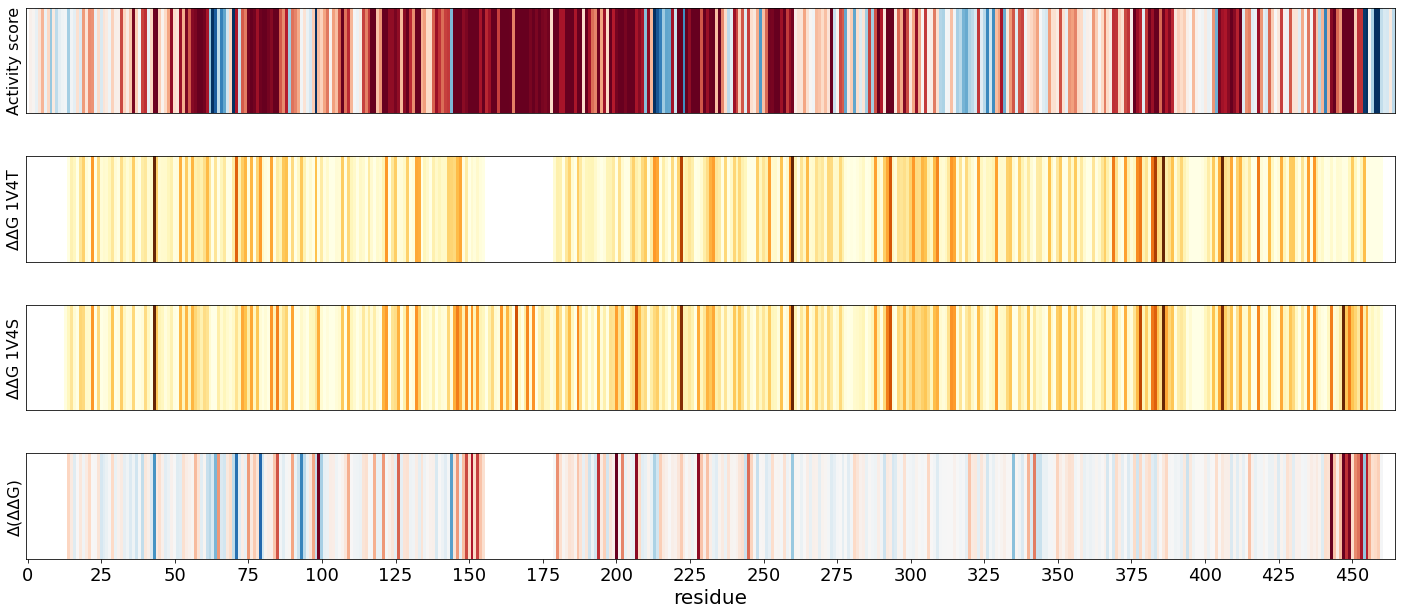

In [76]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2),(ax3),(ax4)) = plt.subplots(4,1,figsize=(20,8.4))
plt.tight_layout()

ax1.imshow(GCK_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Activity score',fontsize=16)

ax2.imshow(rosetta_GCK_1v4t_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('\u0394\u0394G 1V4T',fontsize=16)


ax3.imshow(rosetta_GCK_1v4s_ddg_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=10,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('\u0394\u0394G 1V4S',fontsize=16)


ax4.imshow(rosetta_diff_ddg_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=-5,vmax=5,interpolation='nearest')
ax4.set_yticks([])
ax4.set_ylabel('\u0394(\u0394\u0394G)',fontsize=16)
ax4.xaxis.set_ticks(np.arange(0, len(GCK_WT_sequence), 25))

ax4.set_xlabel("residue")
plt.savefig('../Figures/GCK_heatmap_ddg_diff_res.pdf',dpi=300, facecolor='w')

In [77]:
print_chimera_x_attribute_file(rosetta_GCK_1v4s_ddg_avg,rosetta_GCK_1v4s_ddg_avg,'../output/chimera_rosetta_GCK_1v4s_ddg.txt')

In [78]:
print_chimera_x_attribute_file(rosetta_GCK_1v4t_ddg_avg,rosetta_GCK_1v4t_ddg_avg,'../output/chimera_rosetta_GCK_1v4t_ddg.txt',model_id='#2')

In [79]:
print_chimera_x_attribute_file(rosetta_diff_ddg_med,rosetta_diff_ddg_med,'../output/chimera_rosetta_GCK_diff_med_ddg.txt',model_id='#1')

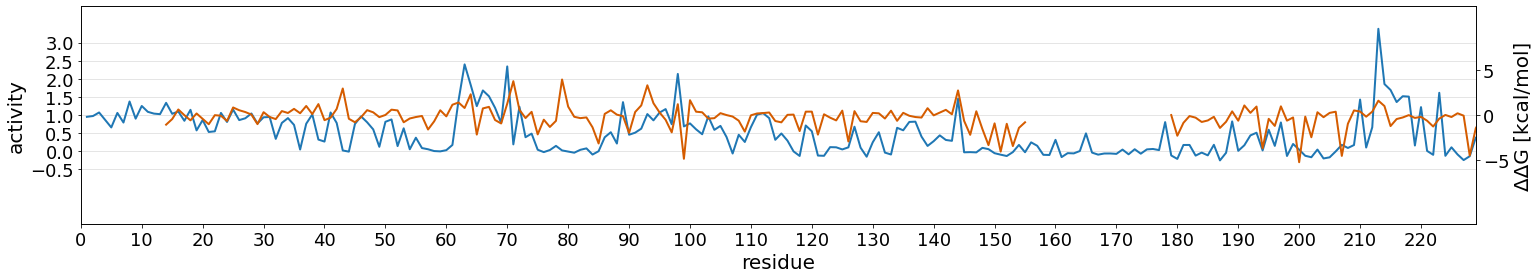

In [127]:
fig, ax1 = plt.subplots(figsize=(25,4))

x=[ i for i in range(len(GCK_scores_med)) ]
x=np.array(x)
 
lns1=ax1.plot(x,GCK_scores_med, label='Activity score',lw=2)

ax1.set_xlabel('residue')
ax1.set_ylabel('activity')
ax1.set_ylim(-2,4)
ax1.set_yticks(np.arange(-0.5,3.5,0.5))


ax2=ax1.twinx()
lns2=ax2.plot(x,rosetta_diff_ddg_med,label='Rosetta_score',color='#d55c00',lw=2)
ax2.set_ylim(-12,12)
ax2.set_yticks(np.arange(-5,6,5))
ax2.set_ylabel("\u0394\u0394G [kcal/mol]")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.grid(axis='y', alpha=0.4)
plt.xlim(0,229)
plt.xticks(np.arange(0,229,10))

plt.savefig('../Figures/GCK_heatmap_dddg_line_1.pdf',dpi=300, facecolor='w')

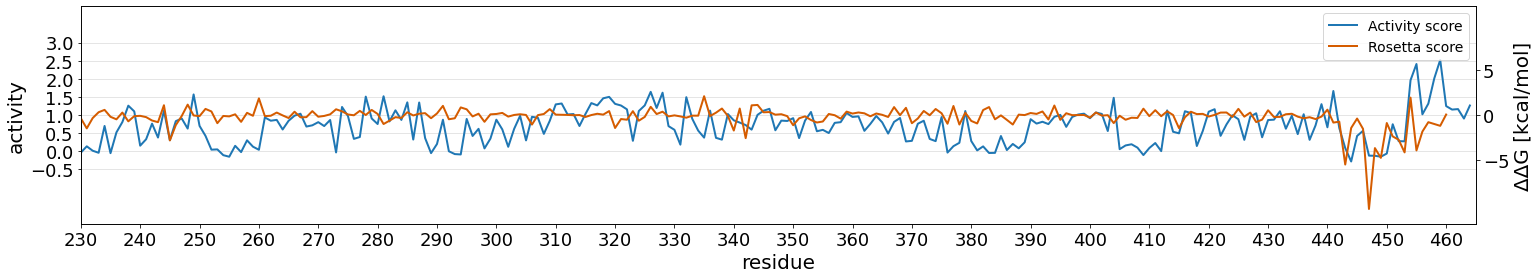

In [128]:
fig, ax1 = plt.subplots(figsize=(25,4))

x=[ i for i in range(len(GCK_scores_med)) ]
x=np.array(x)
 
lns1=ax1.plot(x,GCK_scores_med, label='Activity score',lw=2)

ax1.set_xlabel('residue')
ax1.set_ylabel('activity')
ax1.set_ylim(-2,4)
ax1.set_yticks(np.arange(-0.5,3.5,0.5))


ax2=ax1.twinx()
lns2=ax2.plot(x,rosetta_diff_ddg_med,label='Rosetta score',color='#d55c00',lw=2)
ax2.set_ylim(-12,12)
ax2.set_yticks(np.arange(-5,6,5))
ax2.set_ylabel("\u0394\u0394G [kcal/mol]")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.grid(axis='y', alpha=0.4)
plt.xlim(230,len(GCK_WT_sequence))
plt.xticks(np.arange(230,len(GCK_WT_sequence),10))

plt.savefig('../Figures/GCK_heatmap_dddg_line_2.pdf',dpi=300, facecolor='w')

## selected

In [109]:
list_dddg_selected=['T65I', 'A456V', 'Y215A', 'W99R', 'Y214A', 'V455M', 'Y214C']

list_dddg_ddg_1v4s=[]
list_dddg_ddg_1v4t=[]
for i in list_dddg_selected:
    list_dddg_ddg_1v4s.append(rosetta_GCK_1v4s_ddg[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
    list_dddg_ddg_1v4t.append(rosetta_GCK_1v4t_ddg[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])

In [110]:
df_diff_selected=pd.DataFrame({'mutation':list_dddg_selected,'ddg_1v4s': list_dddg_ddg_1v4s,'ddg_1v4t': list_dddg_ddg_1v4t})

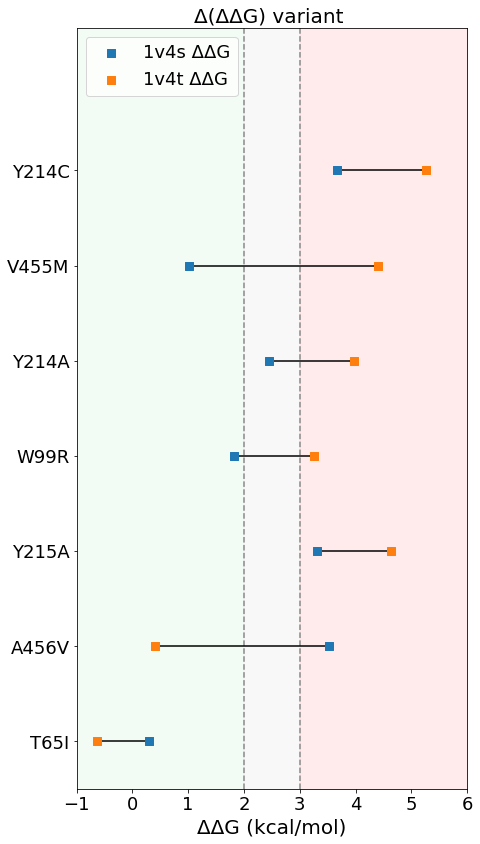

In [111]:
fig,(ax2) = plt.subplots(1,1,figsize=(7,14))

for i in range(len(df_diff_selected['mutation'])):
    ax2.plot([df_diff_selected['ddg_1v4t'][i],df_diff_selected['ddg_1v4s'][i]],[i,i],color='k',zorder=1)


ax2.scatter(df_diff_selected['ddg_1v4s'],[i for i in range(len(df_diff_selected['mutation']))],zorder=2,marker='s',s=50,label='1v4s \u0394\u0394G')
ax2.scatter(df_diff_selected['ddg_1v4t'],[i for i in range(len(df_diff_selected['mutation']))],zorder=2,marker='s',s=50,label='1v4t \u0394\u0394G')

ax2.set_yticks([i for i in range(len(df_diff_selected['mutation']))])
ax2.set_yticklabels(df_diff_selected['mutation'])
ax2.set_xlabel('\u0394\u0394G (kcal/mol)')
ax2.set_title('\u0394(\u0394\u0394G) variant ',fontsize=20)
ax2.set_ylim(-0.5,len(df_diff_selected['mutation'])+0.5)
ax2.set_xlim(-1,6)
ax2.legend(fontsize=18,loc='upper left')


ax2.plot([2,2],[-0.5,len(df_diff_selected['mutation'])+0.5],c='#898989',ls='--',zorder=0)
ax2.plot([3,3],[-0.5,len(df_diff_selected['mutation'])+0.5],c='#898989',ls='--',zorder=0)
x = np.arange(-1, 2, 0.01)
ax2.fill_between(x,-0.5,len(df_diff_selected['mutation'])+0.5,zorder=-10,color='#C2EBC8',alpha=0.2)
x = np.arange(2, 3, 0.01)
ax2.fill_between(x,-0.5,len(df_diff_selected['mutation'])+0.5,zorder=-10,color='#DCDCDC',alpha=0.2)
x = np.arange(3, 6, 0.01)
ax2.fill_between(x,-0.5,len(df_diff_selected['mutation'])+0.5,zorder=-10,color='#FF9F9F',alpha=0.2)


plt.savefig('../figures/GCK_ddg_diff_selected_variants.pdf')

In [112]:
count=0
count_stable=0
count_close_less=0
for i,n in enumerate(GCK_scores.flatten()):
    if n>=1.18:
        count+=1
        if rosetta_GCK_1v4s_ddg.flatten()[i]<2:
            count_stable+=1
            if rosetta_GCK_1v4t_ddg.flatten()[i]>rosetta_GCK_1v4s_ddg.flatten()[i]+0.25:
                count_close_less+=1
print('hyperactivating stable in close conformation (<2kcalmol): ', count_stable, ' out of',count,' (', count_stable/count*100,'%)')
print('and where close is favorite over super-open: ', count_close_less,' out of',count_stable, ' (', count_close_less/count_stable*100,'%)')

hyperactivating stable in close conformation (<2kcalmol):  1304  out of 1803  ( 72.32390460343872 %)
and where close is favorite over super-open:  467  out of 1304  ( 35.81288343558282 %)


In [113]:
df_list_to_create=[]
for (i,j), n in ndenumerate(GCK_scores):
    if n>=1.18:
        if rosetta_GCK_1v4s_ddg[i,j] < 2:
            if rosetta_GCK_1v4t_ddg[i,j] > rosetta_GCK_1v4s_ddg[i,j] + 0.25:
                df_list_to_create.append([ str(GCK_WT_sequence[i])+str(i+1)+str(alphabetAA_D_L[j+1]) , n, rosetta_GCK_1v4s_ddg[i,j], rosetta_GCK_1v4t_ddg[i,j], rosetta_diff_ddg[i,j]])

df_hyperactivating_table=pd.DataFrame(df_list_to_create, columns={'variant','activity_score','ddg_1v4s','ddg_1v4t','dddG'})


In [114]:
df_hyperactivating_table.to_csv('../Output/GCK_hyperactivating_variants_table.csv',sep=',')

### Score distribution Analysis


#### MAVE scores

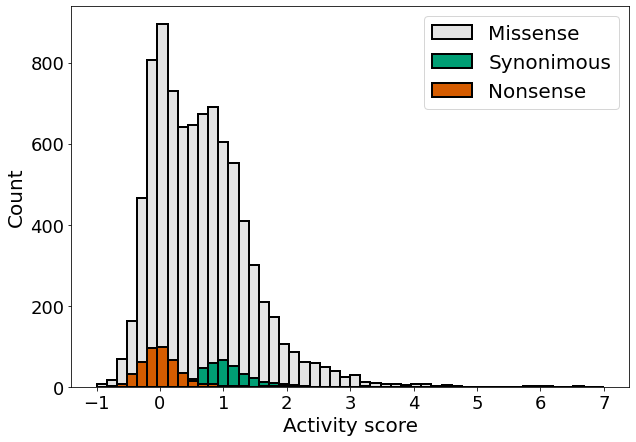

In [115]:
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(GCK_scores.flatten(),bins=50, range=(-1,7),facecolor='#e3e3e3',edgecolor='k',lw=2,label='Missense')
ax.hist(GCK_synonimous_mutations.flatten(),bins=50,range=(-1,7),facecolor='#009E74',edgecolor='k',lw=2,label='Synonimous')
ax.hist(GCK_stop_mutations.flatten(),bins=50,range=(-1,7),facecolor='#d55c00',edgecolor='k',lw=2,label='Nonsense')

ax.legend(fontsize=20)
ax.set_xlabel('Activity score')
ax.set_ylabel('Count')


plt.savefig('../figures/hist_GCK_score_syn_ter.pdf',tight_layout=True)

In [116]:
count=[0,0,0]
for i in GCK_scores.flatten():
    if np.isnan(i)!= True:
        count[0]+=1
        if i <0.6:
            count[1]+=1
        if i >1.4:
            count[2]+=1
print( 'under:' ,count[1], ' out of',count[0],' (', count[1]/count[0]*100,'%)')
print( 'over:' ,count[2], ' out of',count[0],' (', count[2]/count[0]*100,'%)')

under: 4442  out of 8570  ( 51.83197199533256 %)
over: 1198  out of 8570  ( 13.978996499416569 %)


## Correlations with experiments:


pearson's r: 0.443113485041652
boostraping confidence interval: ConfidenceInterval(low=0.42521411174272117, high=0.4593541017242273)


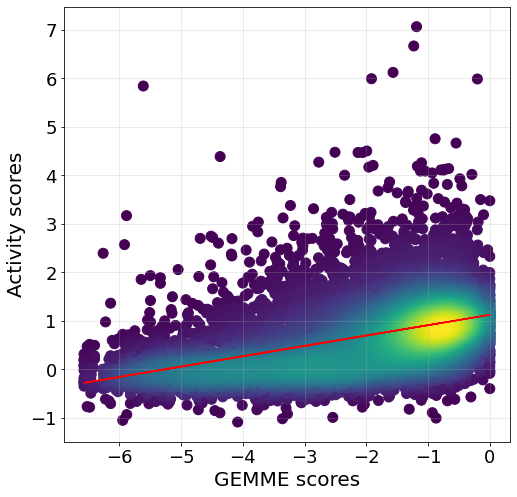

In [117]:
correlation_plot(coevo_GCK_scores.flatten(),GCK_scores.flatten(),'GEMME scores', 'Activity scores')

plt.savefig('../Figures/GCK_correlation_GEMME_fullMAVE.pdf',dpi=300, facecolor='w')

pearson's r: 0.6336290584012223
boostraping confidence interval: ConfidenceInterval(low=0.5715649727514376, high=0.6815525425131828)


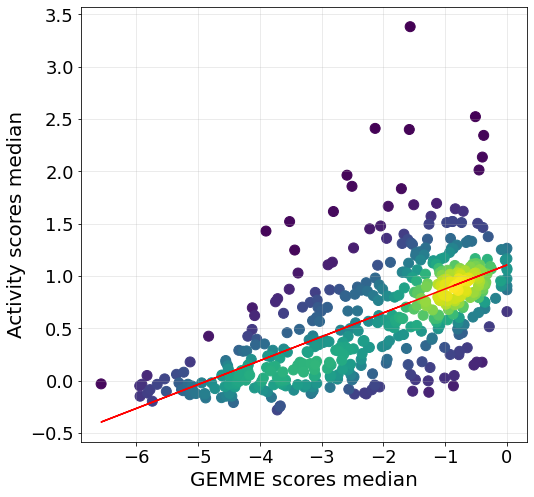

In [118]:
correlation_plot(coevo_GCK_scores_med.flatten(),GCK_scores_med.flatten(),'GEMME scores median', 'Activity scores median')
plt.savefig('../Figures/GCK_correlation_GEMME_fullMAVE_res.pdf',dpi=300, facecolor='w')

pearson's r: 0.5232002167818933
boostraping confidence interval: ConfidenceInterval(low=0.5056216827163724, high=0.540053782381516)


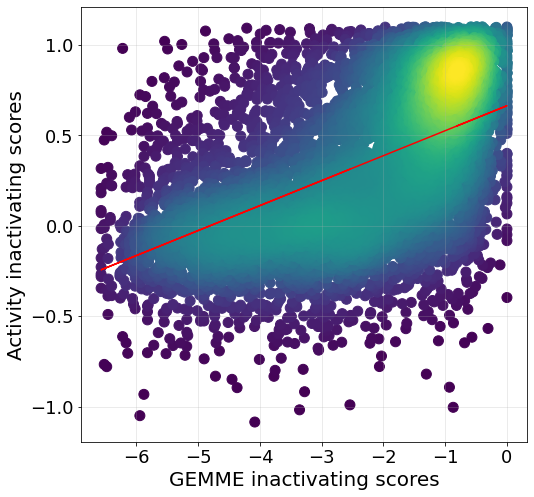

In [119]:
correlation_plot(coevo_GCK_scores.flatten(),GCK_scores_inactivating.flatten(),'GEMME inactivating scores', 'Activity inactivating scores')

plt.savefig('../Figures/GCK_correlation_GEMME_inactivatingMAVE.pdf',dpi=300, facecolor='w')

pearson's r: 0.7355942926559692
boostraping confidence interval: ConfidenceInterval(low=0.6921053182301432, high=0.7720244351975759)


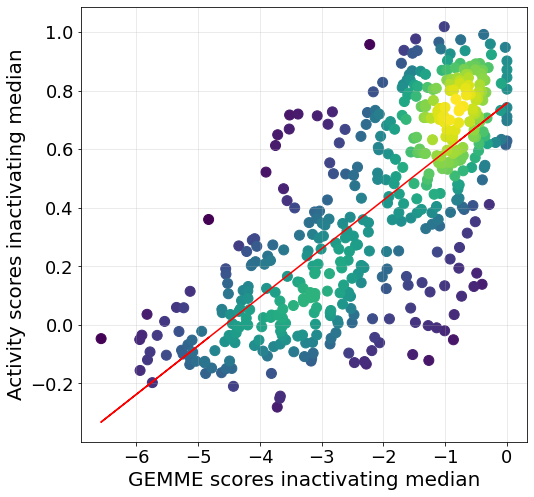

In [120]:
correlation_plot(coevo_GCK_scores_med.flatten(),GCK_scores_inactivating_med.flatten(),'GEMME scores inactivating median', 'Activity scores inactivating median')

plt.savefig('../Figures/GCK_correlation_GEMME_inactivatingMAVE_res.pdf',dpi=300, facecolor='w')

pearson's r: -0.4586250488870105
boostraping confidence interval: ConfidenceInterval(low=-0.5183601708172587, high=-0.3933413794448496)


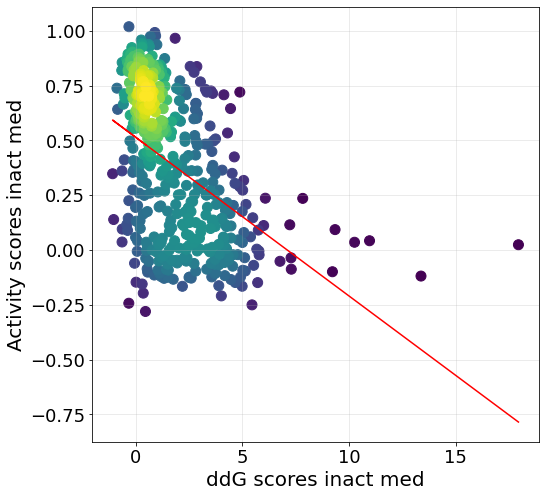

In [121]:
correlation_plot(rosetta_GCK_1v4s_ddg_avg.flatten(),GCK_scores_inactivating_med.flatten(),'ddG scores inact med', 'Activity scores inact med')

plt.savefig('../Figures/GCK_correlation_GEMME_inactivatingMAVE_res.pdf',dpi=300, facecolor='w')

pearson's r: -0.2754386068614871
boostraping confidence interval: ConfidenceInterval(low=-0.2926560230802518, high=-0.2565841333069121)


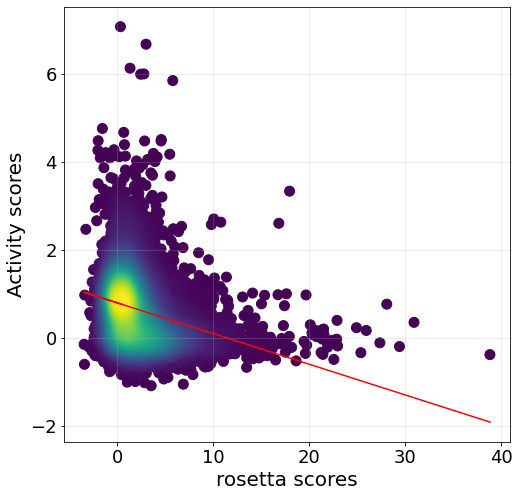

In [122]:
correlation_plot(rosetta_GCK_1v4s_ddg.flatten(),GCK_scores.flatten(),'rosetta scores', 'Activity scores')
plt.savefig('../Figures/GCK_correlation_ddg1v4s_fullMAVE_res.pdf',dpi=300, facecolor='w')

pearson's r: -0.19215002460498384
boostraping confidence interval: ConfidenceInterval(low=-0.21237943862785583, high=-0.16966515336948731)


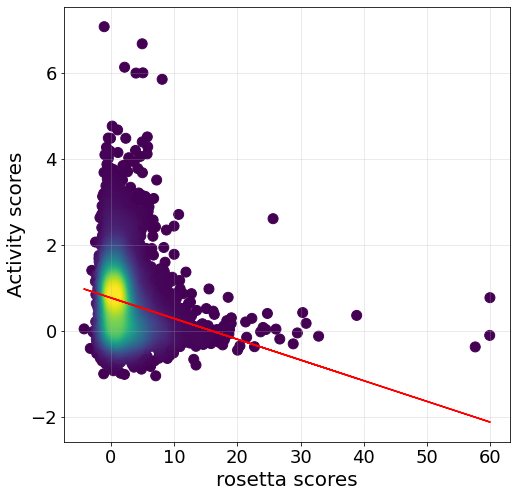

In [123]:
correlation_plot(rosetta_GCK_1v4t_ddg.flatten(), GCK_scores.flatten(),'rosetta scores', 'Activity scores')
plt.savefig('../Figures/GCK_correlation_rosetta1v4t_fullMAVE_res.pdf',dpi=300, facecolor='w')

#### correlation imputed vs experimental

pearson's r: 0.9892393279422858
boostraping confidence interval: ConfidenceInterval(low=0.9879225159683648, high=0.9903337206055545)


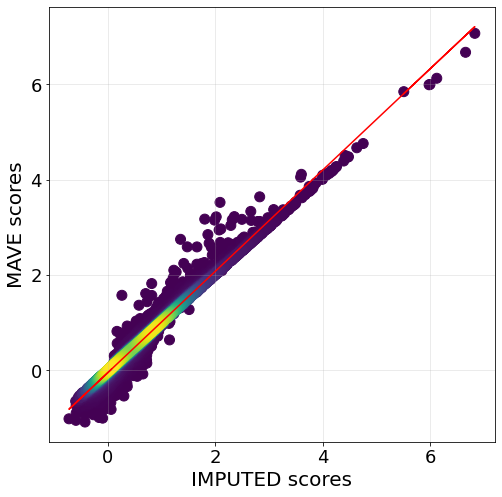

In [124]:
correlation_plot(GCK_imputed.flatten(),GCK_scores.flatten(),'IMPUTED scores', 'MAVE scores')
#plt.xlim(0,-7)
plt.savefig('../Figures/GCK_correlation_GEMME_fullMAVE.png',dpi=300, facecolor='w')

## Variant analysis

In [125]:
### Load main pathogenic data as df

In [126]:
benign_variant=['A11T','G68D','T342P']

In [127]:
mutation_disease=[]
extract_disease=[]
extract_disease_digits=[]
extract_mave=[]
extract_mave_res=[]
extract_gemme=[]
extract_gemme_res=[]
extract_ddg=[]
extract_gnomad=[]
extract_ddg_t=[]
for i in range(GCK_disease.shape[0]):
    for j in range(GCK_disease.shape[1]):
        if np.isnan(GCK_disease[i,j]):
            pass
        else:
            mutation_disease.append(GCK_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
            if  GCK_disease[i,j]==1:
                extract_disease.append('MODY')
                extract_disease_digits.append(1)
                
            elif GCK_disease[i,j] == 2:
                extract_disease.append('HH')
                extract_disease_digits.append(2)
                
            if np.isnan(gnomad_GCK_freq_db_matrix[i,j]):
                extract_gnomad.append(np.inf)
            else:
                extract_gnomad.append(gnomad_GCK_freq_db_matrix[i,j])
            extract_mave.append(GCK_scores[i,j])
            extract_mave_res.append(GCK_scores_med[i])
            extract_gemme.append(coevo_GCK_scores[i,j])
            extract_gemme_res.append(coevo_GCK_scores_med[i])
            extract_ddg.append(rosetta_GCK_1v4s_ddg[i,j])
            extract_ddg_t.append(rosetta_GCK_1v4t_ddg[i,j])
                


In [128]:
for m in benign_variant:
    i,j= int(m[1:-1])-1, int(alphabetAA_L_D[m[-1:]])-1

    mutation_disease.append(GCK_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
    extract_disease.append('Benign')
    extract_disease_digits.append(0)
    extract_mave.append(GCK_scores[i,j])
    extract_mave_res.append(GCK_scores_med[i])
    extract_gemme.append(coevo_GCK_scores[i,j])
    extract_gemme_res.append(coevo_GCK_scores_med[i])
    extract_ddg.append(rosetta_GCK_1v4s_ddg[i,j])
    extract_ddg_t.append(rosetta_GCK_1v4t_ddg[i,j])
        
    if np.isnan(gnomad_GCK_freq_db_matrix[i,j]):
        extract_gnomad.append(np.inf)
    else:
        extract_gnomad.append(gnomad_GCK_freq_db_matrix[i,j])
                


In [129]:
df_disease_benign= pd.DataFrame({'mutation': mutation_disease,'disease':extract_disease ,'mave':extract_mave,'mave_res':extract_mave_res, 'gemme': extract_gemme,'gemme_res': extract_gemme_res, 'ddg_1v4s':extract_ddg,'ddg_1v4t':extract_ddg_t,'freq_gnomad':extract_gnomad})



#### inputing value for G68D to G68N


In [130]:
df_disease_benign['mave'][72]=GCK_imputed[67,int(alphabetAA_L_D['D'])-1]

df_disease_benign.to_excel('../Output/df_disease_df_export.xlsx')

### ROC - AUC

In [69]:
thresholds_inactivating=[0.65]

ROC_MODY=np.empty(len(thresholds_inactivating),dtype=float)
ROC_MODY[:]=np.nan

for i,n in enumerate(thresholds_inactivating):
        class_clin=[]
        class_mave=[]
        #load list with class from cloinvar e mave
        for k in range(len(df_disease_benign['mutation'])):
            if np.isnan(df_disease_benign['mave'][k])!=True:
                if df_disease_benign['disease'][k]=='Benign':
                    class_clin.append(0)
                    if df_disease_benign['mave'][k]<n:
                        class_mave.append(1)
                    else:
                        class_mave.append(0)
                elif df_disease_benign['disease'][k]=='MODY':
                    class_clin.append(1)
                    if df_disease_benign['mave'][k]<n:
                        class_mave.append(1)
                    else:
                        class_mave.append(0)
                    
                else:
                    pass
        
        
        
        fpr, tpr, _ = roc_curve(class_clin, class_mave)
        roc_auc = auc(fpr, tpr)
        
        print(n,tpr,roc_auc)

0.65 [0.         0.76666667 1.        ] 0.8833333333333333


In [70]:
thresholds_hyperactivating=[1.18]

ROC_HH=np.empty(len(thresholds_hyperactivating),dtype=float)
ROC_HH[:]=np.nan

for i,n in enumerate(thresholds_hyperactivating):
        class_clin=[]
        class_mave=[]
        #load list with class from cloinvar e mave
        for k in range(len(df_disease_benign['mutation'])):
            if np.isnan(df_disease_benign['mave'][k])!=True:
                if df_disease_benign['disease'][k]=='Benign':
                    class_clin.append(0)
                    if df_disease_benign['mave'][k]>n:
                        class_mave.append(1)
                    else:
                        class_mave.append(0)
                elif df_disease_benign['disease'][k]=='HH':
                    class_clin.append(1)
                    if df_disease_benign['mave'][k]>n:
                        class_mave.append(1)
                    else:
                        class_mave.append(0)
                    
                else:
                    pass
        
        fpr, tpr, _ = roc_curve(class_clin, class_mave)
        roc_auc = auc(fpr, tpr)

        print(n,tpr,roc_auc)

1.18 [0.    0.875 1.   ] 0.9375


### gnomad frequencies

71    0.657910
72    1.172500
73    0.661667
Name: mave, dtype: float64


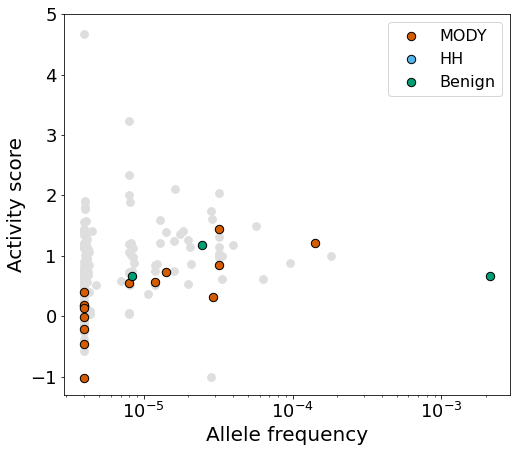

In [71]:
fig,ax=plt.subplots(1,1,figsize=(8,7))


ax.scatter(gnomad_GCK_freq_db_matrix,GCK_scores,c='#DEDEDE',s=60)


idx = np.isfinite(df_disease_benign[df_disease_benign['disease']=='MODY']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease_benign[df_disease_benign['disease']=='MODY']['mave'].to_numpy() )
ax.scatter(df_disease_benign['freq_gnomad'][df_disease_benign['disease']=='MODY'].to_numpy()[idx],df_disease_benign['mave'][df_disease_benign['disease']=='MODY'].to_numpy()[idx],c='#d55c00',s=70,edgecolors='k',label='MODY')

idx = np.isfinite(df_disease_benign[df_disease_benign['disease']=='HH']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease_benign[df_disease_benign['disease']=='HH']['mave'].to_numpy() )
ax.scatter(df_disease_benign['freq_gnomad'][df_disease_benign['disease']=='HH'].to_numpy()[idx],df_disease_benign['mave'][df_disease_benign['disease']=='HH'].to_numpy()[idx],c='#56b4e9',s=70,edgecolors='k',label='HH')
print(df_disease_benign[df_disease_benign['disease']=='Benign']['mave'])
idx = np.isfinite(df_disease_benign[df_disease_benign['disease']=='Benign']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease_benign[df_disease_benign['disease']=='Benign']['mave'].to_numpy() )
ax.scatter(df_disease_benign[df_disease_benign['disease']=='Benign']['freq_gnomad'].to_numpy()[idx],df_disease_benign[df_disease_benign['disease']=='Benign']['mave'].to_numpy()[idx],c='#009e74',s=70,edgecolors='k',label='Benign')
ax.set_xscale('log')
ax.set_xlabel('Allele frequency')
ax.set_ylabel('Activity score')
ax.set_ylim(-1.3,5)
ax.legend(fontsize=16)
plt.savefig('../figures/GCK_gnomad_valid_frequency_variants.pdf')

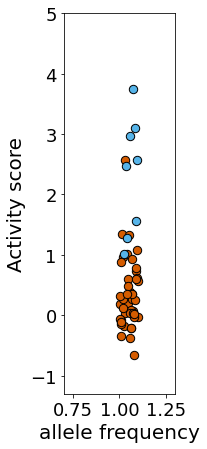

In [72]:
fig,ax=plt.subplots(1,1,figsize=(2,7))
temp=df_disease_benign
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='MODY':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            
ax.scatter([1+random()/10 for i in range(0,len(temp_array))],temp_array,c='#d55c00',s=70,edgecolors='k')


temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='HH':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            

ax.scatter([1+random()/10 for i in range(0,len(temp_array))],temp_array,c='#56b4e9',s=70,edgecolor='k')


ax.set_ylim(-1.3,5)
ax.set_xlim(0.7,1.3)
ax.set_xlabel('allele frequency')
ax.set_ylabel('Activity score')
plt.savefig('../figures/GCK_gnomad_null_frequency_variants.pdf')

#### rainbow plot

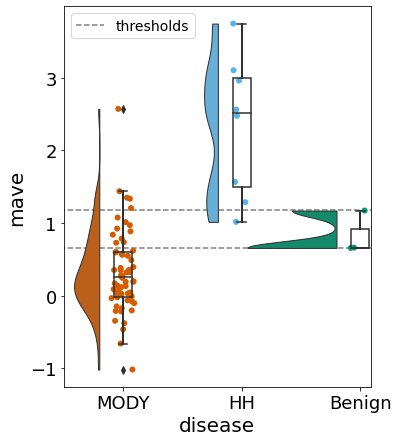

In [73]:
#same thing with a single command: now x **must** be the categorical value
dx = "disease"; dy = "mave"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(5.5, 7))

ax1=pt.RainCloud(x = dx, y = dy, data = df_disease_benign, palette = ['#d55c00','#56b4e9','#009e74'],
      bw = sigma,width_viol = 1.5, ax = ax, orient = ort,point_size=6)

ax1.plot([-1,3],[0.66,0.66],c='gray',ls='--',zorder=-1,label='thresholds')
ax1.plot([-1,3],[1.18,1.18],c='gray',ls='--',zorder=-1)

ax1.legend()

plt.savefig('../figures/GKC_pathogenic_benign_raincloud.pdf',tight_layout=True)

In [74]:
count=[0,0,0]
count_total=0
count_under_MODY=0
count_over_HH=0
for i,n in enumerate(df_disease_benign['disease']):
    count[0]+=1
    if n=='MODY':
        count[1]+=1
        if df_disease_benign['mave'][i]<0.66:
            count_total+=1
            count_under_MODY+=1
    if n=='HH':
        count[2]+=1
        if df_disease_benign['mave'][i]>1.17:
            count_total+=1
            count_over_HH+=1
print('total detected: ', count_total, ' out of',count[0],' (', count_total/count[0]*100,'%)')
print('MODY detected: ', count_under_MODY,' out of',count[1], ' (', count_under_MODY/count[1]*100,'%)')
print('HH detected: ', count_over_HH,' out of',count[2], ' (', count_over_HH/count[2]*100,'%)')

total detected:  53  out of 74  ( 71.62162162162163 %)
MODY detected:  46  out of 62  ( 74.19354838709677 %)
HH detected:  7  out of 9  ( 77.77777777777779 %)


## Kinetics

In [144]:
extract_disease=['None']
extract_mave=[1]
extract_gemme=[0]
extract_ddg=[0]

for m in df_kinetics['mutation_3l'][1:]:
    i,j= int(m[1:-1])-1, int(alphabetAA_L_D[m[-1:]])-1
    if  GCK_disease[i,j]==1:
        extract_disease.append('MODY')

    elif GCK_disease[i,j] == 2:
        extract_disease.append('HH')
    else:
        extract_disease.append('None')

    extract_gemme.append(coevo_GCK_scores[i,j])

    if np.isnan(rosetta_GCK_1v4s_ddg[i,j]):
        extract_ddg.append(np.nan)
    else:
        extract_ddg.append(rosetta_GCK_1v4s_ddg[i,j])
    
    if np.isnan(GCK_scores[i,j]):
        extract_mave.append(np.nan)
    else:
        extract_mave.append(GCK_scores[i,j])

In [145]:
df_kinetics['MAVE']=extract_mave
df_kinetics['GEMME']=extract_gemme
df_kinetics['ROSETTA']=extract_ddg
df_kinetics['DISEASE']=extract_disease

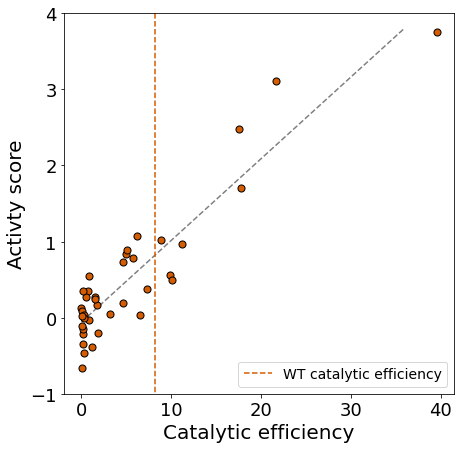

In [146]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_kinetics['catalytic_efficiency'][1:],df_kinetics['MAVE'][1:],facecolor='#d55c00',edgecolor='k',s=50)
ax.set_xlabel('Catalytic efficiency')
ax.set_ylabel('Activty score')

ax.plot([df_kinetics['catalytic_efficiency'][0],df_kinetics['catalytic_efficiency'][0]],[-1.5,5],'r--',color='#d55c00',label='WT catalytic efficiency')
ax.set_ylim(-1,4)
ax.legend()

idx = np.isfinite(df_kinetics['catalytic_efficiency'].to_numpy()[1:]) & np.isfinite(df_kinetics['MAVE'].to_numpy()[1:])

a,b=np.polyfit(df_kinetics['catalytic_efficiency'].to_numpy()[1:][idx], df_kinetics['MAVE'].to_numpy()[1:][idx],1)

x=np.arange(0,36,0.1)
y=a*x+b

plt.plot(x,y,ls='--',c='gray',zorder=-1)


plt.savefig('../Figures/GCK_kinetics_scatter.pdf', tight_layout=True)


In [147]:
print(sp.stats.spearmanr(df_kinetics['catalytic_efficiency'].to_numpy()[1:][idx], df_kinetics['MAVE'].to_numpy()[1:][idx]))

rng = np.random.default_rng()
res = bootstrap((df_kinetics['catalytic_efficiency'].to_numpy()[1:][idx], df_kinetics['MAVE'].to_numpy()[1:][idx]), spearman_output, vectorized=False, paired=True,
                random_state=rng)
    
print("boostraping confidence interval:", res.confidence_interval)

SpearmanrResult(correlation=0.7643068169383959, pvalue=2.34575096951053e-08)
boostraping confidence interval: ConfidenceInterval(low=0.5770104931686421, high=0.884663127742195)


## Glucose

In [130]:
extract_mave=[]
extract_gemme=[]
extract_ddg=[]

for m in df_glucose['mutation_3l']:
    if m =='nan':
        extract_mave.append(np.nan)
        extract_gemme.append(np.nan)
        extract_ddg.append(np.nan)
    else:
        i,j= int(m[1:-1])-1, int(alphabetAA_L_D[m[-1:]])-1

        extract_gemme.append(coevo_GCK_scores[i,j])

        if np.isnan(rosetta_GCK_1v4s_ddg[i,j]):
            extract_ddg.append(np.nan)
        else:
            extract_ddg.append(rosetta_GCK_1v4s_ddg[i,j])

        if np.isnan(GCK_scores[i,j]):
            extract_mave.append(np.nan)
        else:
            extract_mave.append(GCK_scores[i,j])

In [131]:
GCK_scores[2,:]

array([1.05050524, 0.96763201,        nan, 0.58644415, 1.09230473,
       0.98033064, 1.27358804, 0.77541571, 0.61781419, 1.21797525,
       0.8082939 ,        nan, 0.84510861, 1.15247244, 1.4380789 ,
       1.09818469, 0.39462982, 0.52479177, 1.54131692, 0.96495525])

In [132]:
df_glucose['MAVE']=extract_mave
df_glucose['GEMME']=extract_gemme
df_glucose['ROSETTA']=extract_ddg

In [133]:
df_glucose_under_9nm=df_glucose[df_glucose['Fasting_glucose']<9.0].reset_index(drop=True)

In [134]:
## drop M3V because is from a different transcrip
df_glucose_under_9nm=df_glucose_under_9nm.drop(12,axis=0).reset_index(drop=True)

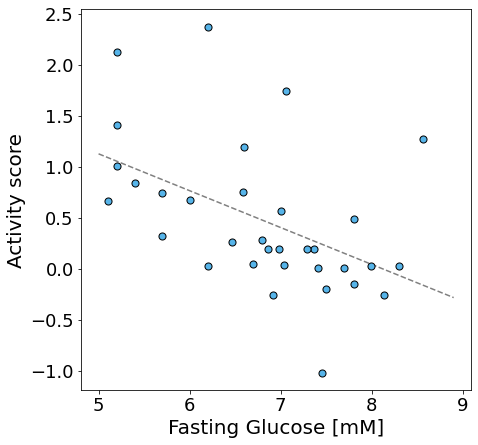

In [135]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_glucose_under_9nm['Fasting_glucose'],df_glucose_under_9nm['MAVE'],facecolor='#56b4e9',edgecolor='k',s=50)
ax.set_xlabel('Fasting Glucose [mM]')
ax.set_ylabel('Activity score')

idx = np.isfinite(df_glucose_under_9nm['Fasting_glucose'].to_numpy()) & np.isfinite(df_glucose_under_9nm['MAVE'].to_numpy())

a,b=np.polyfit(df_glucose_under_9nm['Fasting_glucose'].to_numpy()[idx], df_glucose_under_9nm['MAVE'].to_numpy()[idx],1)

x=np.arange(5,9,0.1)
y=a*x+b

plt.plot(x,y,ls='--',c='gray',zorder=-1)


plt.savefig('../Figures/GCK_glucose_scatter.pdf', tight_layout=True)

In [136]:
sp.stats.spearmanr(df_glucose_under_9nm['Fasting_glucose'].to_numpy()[idx], df_glucose_under_9nm['MAVE'].to_numpy()[idx])

SpearmanrResult(correlation=-0.5831241890195157, pvalue=0.00036886437123000724)

In [139]:
rng = np.random.default_rng()
res = bootstrap((df_glucose_under_9nm['Fasting_glucose'].to_numpy()[idx], df_glucose_under_9nm['MAVE'].to_numpy()[idx]), spearman_output, vectorized=False, paired=True,random_state=rng)
    
print("boostraping confidence interval:", res.confidence_interval)

boostraping confidence interval: ConfidenceInterval(low=-0.7872293451204783, high=-0.19384651663807317)
